# Random Forest: make_moons

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reference: https://www.kaggle.com/code/fareselmenshawii/decision-tree-from-scratch

## Generate the Two Moons Data Set

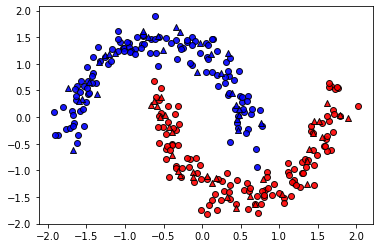

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=300, noise=0.1, random_state=0)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

def plot2Ddata(X_train,X_test,y_train,y_test):
    plt.scatter(X_train[y_train == 0,0],X_train[y_train == 0,1],
                color='b',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_train[y_train == 1,0],X_train[y_train == 1,1],
                color='r',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 0,0],X_test[y_test == 0,1],
                color='b',marker='^',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 1,0],X_test[y_test == 1,1],
                color='r',marker='^',alpha=0.9,edgecolors='k')
    
plot2Ddata(X_train,X_test,y_train,y_test)

## Create Node class, Decision Tree class, and Random Forest Class

In [3]:
class Node:
    def __init__(self, split_data=None, left=None, right=None, value_if_leaf=None):
        self.split_data = split_data        # contains gini, feat, thresh, left_data, right_data 
        self.left = left                    # contains the left child Node
        self.right = right                  # contains the right child Node
        self.value_if_leaf = value_if_leaf  # None if not leaf, predicted value if leaf.

class DecisionTree:
    def __init__(self, min_samples=2, max_depth=10):
        self.min_samples = min_samples      # Min no. of samples to split the nodes
        self.max_depth = max_depth          # Max depth of the decision tree
    
    def find_split(self, data):             # data contains (X, y)
        N = len(data)
        
        # Dictionary of best_split attributes
        best_split = {'gini': 1, 'feat': None, 'thresh': None}
        
        # Get a random feature
        feat = np.random.randint(0, data.shape[1]-1)
        sorted_data = data[data[:, feat].argsort(),:]
        for i in range(N-1):
            left = sorted_data[:(i+1),:]
            right = sorted_data[(i+1):,:]

            p1 = np.sum(left[:,-1]) / (i+1)
            p2 = np.sum(right[:,-1]) / (N - (i+1))
            gini_left = 2 * p1 * (1 - p1);
            gini_right = 2 * p2 * (1 - p2);
            gini = ((i+1) * gini_left + (N - (i+1)) * gini_right) / N

            if gini < best_split["gini"]:
                best_split["gini"] = gini
                best_split["feat"] = feat
                best_split["thresh"] = (left[-1,feat] + right[0,feat]) / 2
                best_split["left_data"] = left
                best_split["right_data"] = right
        
        return best_split
    
    def fit(self, data):
        self.root = self.build_tree(data)
        return self
        
    def build_tree(self, data, curr_depth=0):
        N = data.shape[0]
        if N >= self.min_samples and curr_depth <= self.max_depth and \
            len(np.unique(data[:,-1])) > 1:
            
            best_split = self.find_split(data)
            left_node = self.build_tree(best_split["left_data"], curr_depth+1)
            right_node = self.build_tree(best_split["right_data"], curr_depth+1)
            return Node(split_data=best_split, left=left_node, right=right_node)
        
        leaf_value = 2 * np.sum(data[:,-1]) > N
        return Node(value_if_leaf=leaf_value)
    
    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            nd = self.root
            while nd.value_if_leaf == None:
                if X[i,nd.split_data["feat"]] < nd.split_data["thresh"]:
                    nd = nd.left
                else:
                    nd = nd.right
            y_pred[i] = nd.value_if_leaf
        return y_pred
    
class RandomForest:
    def __init__(self, n_estimators=100, frac_bootstrap=1, min_samples=2, max_depth=10):
        self.n_estimators = n_estimators      # Number of trees
        self.min_samples = min_samples        # Min no. of samples to split the nodes
        self.max_depth = max_depth            # Max depth of the decision tree
        self.frac_bootstrap = frac_bootstrap  # Fraction of entire data for bootstrapping
    
    def fit(self, X, y):
        data = np.hstack((X_train, y_train.reshape(-1,1)))
        self.forest = [DecisionTree(self.min_samples, self.max_depth)] * self.n_estimators
        
        for i in range(self.n_estimators):
            N = int(np.round(self.frac_bootstrap * len(data), 1))
            bootstrap = np.unique(np.random.randint(0,len(data),(N,1)))
            sampled_data = data[bootstrap,:]
            X, y = sampled_data[:,:2], sampled_data[:,-1]
            self.forest[i] = self.forest[i].fit(sampled_data)
        
        return self.forest
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.forest:
            y_pred += tree.predict(X)
            
        return 2 * y_pred > self.n_estimators
        
    def plot_decision(self, X, y):
        nx, ny = 100, 100
        xv, yv = np.meshgrid(np.linspace(-3,3,nx), 
                             np.linspace(-3,3,ny))
        xy = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
        zv = self.predict(xy)
        plt.figure(figsize=(10,7))
        plt.scatter(xy[zv == 0,0], xy[zv == 0,1], c='b', s=10, alpha=0.2)
        plt.scatter(xy[zv == 1,0], xy[zv == 1,1], c='r', s=10, alpha=0.2)
        plt.scatter(X[y == 0,0],X[y == 0,1], color='b', marker='o',
                    alpha=0.9, edgecolors='k', label='(-) Training samples')
        plt.scatter(X[y == 1,0],X[y == 1,1], color='r', marker='o',
                    alpha=0.9, edgecolors='k', label='(+) Training samples')
        plt.legend()
        plt.show()

## Train the Random Forest on the training set

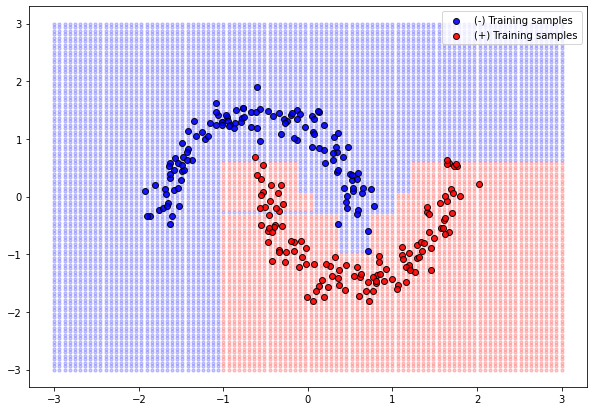

In [4]:
mdl = RandomForest()
mdl.fit(X_train, y_train)
mdl.plot_decision(X_train, y_train)